# Bin correlation as a function of pseudo-count

In [1]:
import numpy as np
import pandas as pd
import pyBigWig as bw
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from scipy.stats import entropy

# parameters
bin_size = 10000
bw_path = '../results/binned_norm_counts'
T = np.arange(0,48,4)
Strands = ['forward', 'reverse']
strand_dict = {'forward':'+', 'reverse':'-', '+':'forward', '-':'reverse'}
CHR = [f'chr{i}' for i in range(1,19)] + ['chrX','chrY','chrM']

n = 1
P = 24
N = len(T)

PC = 10**np.arange(-4,0.001,.5,dtype=float)

In [2]:

for bin_size in [1000]:

    # Load bigWigs
    bw_files = {}
    for t in T:
        sample = f'PRO_SEQ_CT{t:02d}_S{t//4+1}_R1_001'
        bw_files[t] = {}
        for strand in Strands:
            fin = f"{bw_path}/{sample}/NormCoverage_3p_{strand}_bin{bin_size}bp.bw"
            bw_files[t][strand] = bw.open(fin)

    # get data frame
    X = np.zeros((0,len(T)))
    for chr in CHR:
        print(chr)
        df_chr = {}
        for strand in ['forward','reverse']:
            df_chr[strand] = pd.DataFrame(columns=['start','end'])
            for t in T:
                df_t = pd.DataFrame(bw_files[t][strand].intervals(chr))
                df_t.columns = ['start','end',f"{t}"]
                df_chr[strand] = pd.merge(df_chr[strand],df_t,on=['start','end'],how='outer')
            df_chr[strand].sort_values('start',inplace=True)

        # merge forward and reverse (sum)
        df_chr = pd.merge(df_chr['forward'],df_chr['reverse'],on=['start','end'],how='outer')
        for t in T:
            idx_na = df_chr[[f"{t}_x",f"{t}_y"]].isna().all(1)
            df_chr[f"{t}"] = df_chr[[f"{t}_x",f"{t}_y"]].sum(1)
            df_chr.loc[idx_na,f"{t}"] = np.nan
            df_chr.drop([f"{t}_x",f"{t}_y"],axis=1,inplace=True)

        # append to data frame
        X = np.concatenate((X,df_chr[[f"{t}" for t in T]].values),axis=0)


    # remove position with 75% or more missing values (at least 5 out of 12 time points)
    X = X[(np.isnan(X).sum(1) < len(T)*0.75),:]

    # replace missing values with 0
    X[np.isnan(X)] = 0




chr1
chr2
chr3
chr4
chr5
chr6
chr7
chr8
chr9
chr10
chr11
chr12
chr13
chr14
chr15
chr16
chr17
chr18
chrX
chrY
chrM


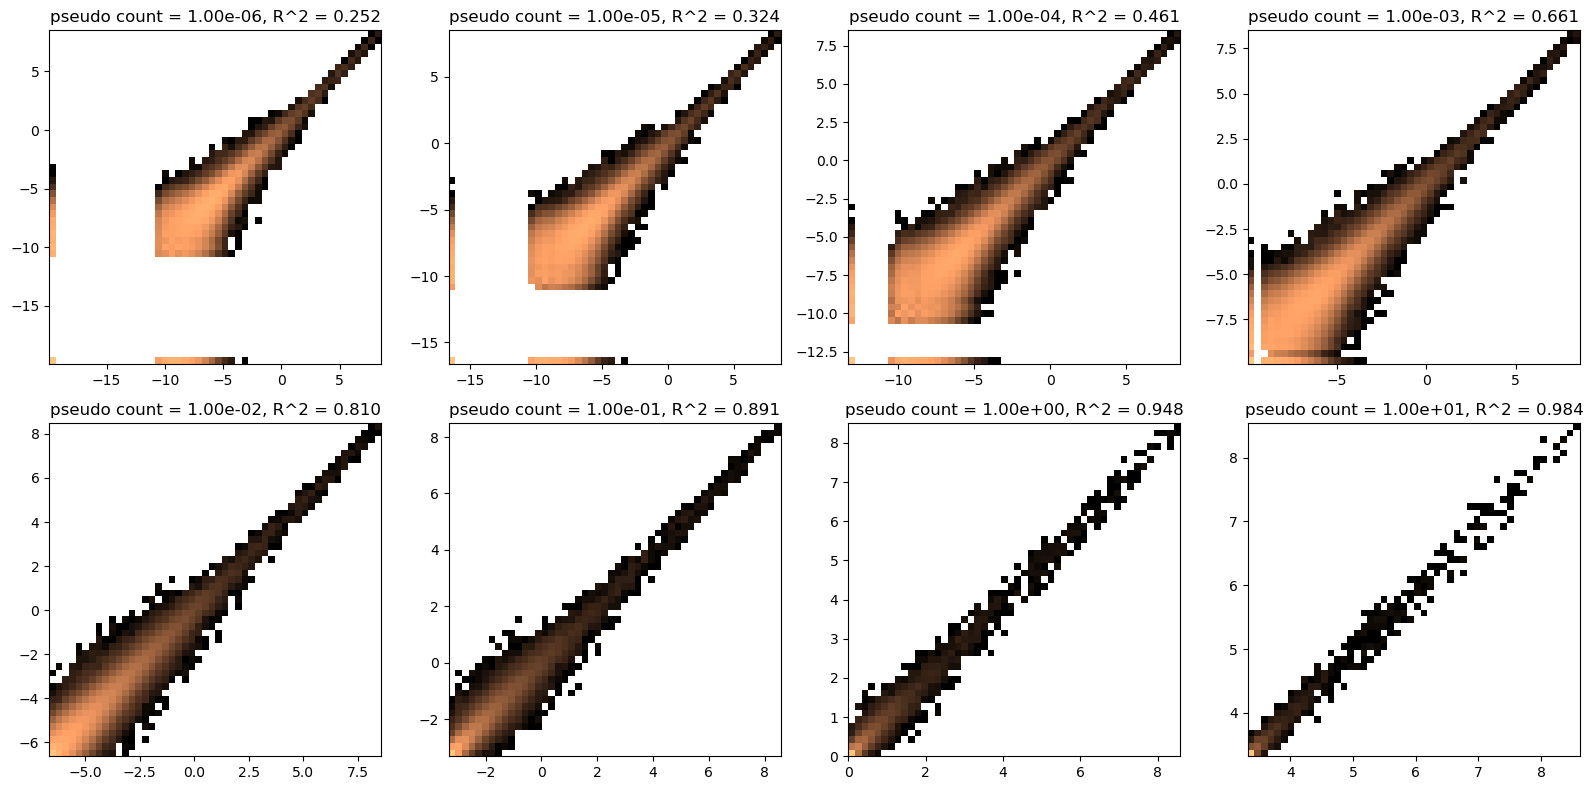

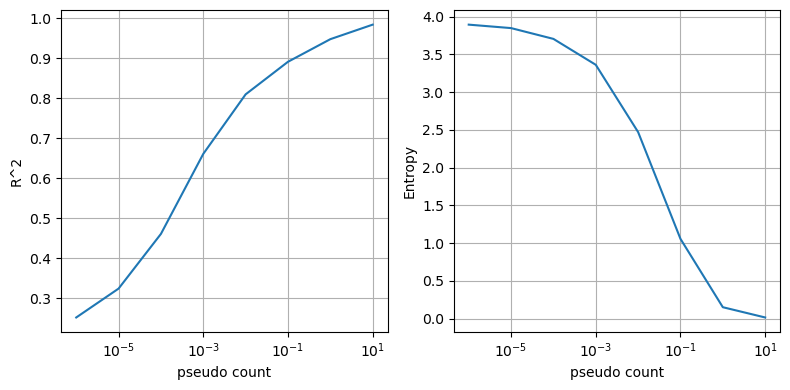

In [8]:

PC = 10**np.arange(-6,1.001,1,dtype=float)



t1 = T<24
t2 = ~t1

pc_R2 = np.zeros((len(PC),2))
pc_R2[:,0] = PC
E = np.zeros((len(PC),2))
E[:,0] = PC

n_col = 4
n_row = np.ceil(len(PC)/n_col).astype(int)

fig, axes = plt.subplots(n_row,n_col,figsize=(n_col*4,n_row*4))
for i,pc in enumerate(PC):

    # add pseudo count
    #X += pc

    if True:
        # take the log of the data
        if pc == 0:
            X_log = X
        else:
            X_log = np.log2(X+pc)

        pc_R2[i,1] = np.corrcoef(X_log[:,t1].flatten(),X_log[:,t2].flatten())[0,1]**2
        E[i,1] = entropy(np.histogram(X_log.mean(1),bins=100,density=True)[0])


    ax = axes.flatten()[i]
    ax.hist2d(X_log[:,t1].flatten(),X_log[:,t2].flatten(),bins=50,cmap='copper',norm=mpl.colors.LogNorm())
    ax.set_title(f'pseudo count = {pc:.2e}, R^2 = {pc_R2[i,1]:.3f}')

fig.tight_layout()

plt.figure(figsize=(8,4))

ax = plt.subplot(121)
ax.plot(pc_R2[:,0],pc_R2[:,1])
ax.set_xlabel('pseudo count')
ax.set_ylabel('R^2')
ax.set_xscale('log')
ax.grid()

ax = plt.subplot(122)
ax.plot(E[:,0],E[:,1])
ax.set_xlabel('pseudo count')
ax.set_ylabel('Entropy')
ax.set_xscale('log')
ax.grid()

plt.tight_layout()
